<font size="+3">Visualize Real and Synthetic Data</font>

# Imports and Settings

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [ ]:
sns.set_style('white')

In [ ]:
path = Path('time_gan')
hdf_store = path / 'TimeSeriesGAN.h5'

In [ ]:
seq_len = 24
n_seq = 86

# Load Data

In [ ]:
experiment = 0

In [ ]:
def get_real_data():
    df = pd.read_hdf(hdf_store, 'data/real').sort_index()

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data()

In [ ]:
n = len(real_data)

In [ ]:
np.asarray(real_data).shape

(566, 24, 86)

In [ ]:
synthetic_data = np.load(path / f'experiment_{experiment:02d}' / 'generated_data.npy')
synthetic_data.shape

(512, 24, 86)

In [ ]:
real_data = real_data[:synthetic_data.shape[0]]

# Prepare Sample

In [ ]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [ ]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [ ]:
real_sample_2d.shape, synthetic_sample_2d.shape

((21500, 24), (21500, 24))

# Visualization in 2D: A Qualitative Assessment of Diversity

## Run PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

## Run t-SNE

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 43000 samples in 0.192s...
[t-SNE] Computed neighbors for 43000 samples in 57.953s...
[t-SNE] Computed conditional probabilities for sample 1000 / 43000
[t-SNE] Computed conditional probabilities for sample 2000 / 43000
[t-SNE] Computed conditional probabilities for sample 3000 / 43000
[t-SNE] Computed conditional probabilities for sample 4000 / 43000
[t-SNE] Computed conditional probabilities for sample 5000 / 43000
[t-SNE] Computed conditional probabilities for sample 6000 / 43000
[t-SNE] Computed conditional probabilities for sample 7000 / 43000
[t-SNE] Computed conditional probabilities for sample 8000 / 43000
[t-SNE] Computed conditional probabilities for sample 9000 / 43000
[t-SNE] Computed conditional probabilities for sample 10000 / 43000
[t-SNE] Computed conditional probabilities for sample 11000 / 43000
[t-SNE] Computed conditional probabilities for sample 12000 / 43000
[t-SNE] Computed conditional probabilities for s

In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

## Plot Result

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Time Series Classification: A quantitative Assessment of Fidelity

## Prepare Data

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(512, 24, 86)

In [ ]:
synthetic_data.shape

(512, 24, 86)

In [ ]:
n_series = real_data.shape[0]

In [ ]:
idx = np.arange(n_series)

In [ ]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [ ]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [ ]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## Create Classifier

In [ ]:
ts_classifier = Sequential([GRU(6, input_shape=(24, 86), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [ ]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [ ]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 6)                 1692      
_________________________________________________________________
OUT (Dense)                  (None, 1)                 7         
Total params: 1,699
Trainable params: 1,699
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [ ]:
ts_classifier.evaluate(x=test_data, y=test_labels)

7/7 [==============================] - 0s 4ms/step - loss: 1.8959 - AUC: 0.1784 - accuracy: 0.2282


[1.8958557844161987, 0.17843341827392578, 0.22815534472465515]

In [ ]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [ ]:
from matplotlib.ticker import FuncFormatter

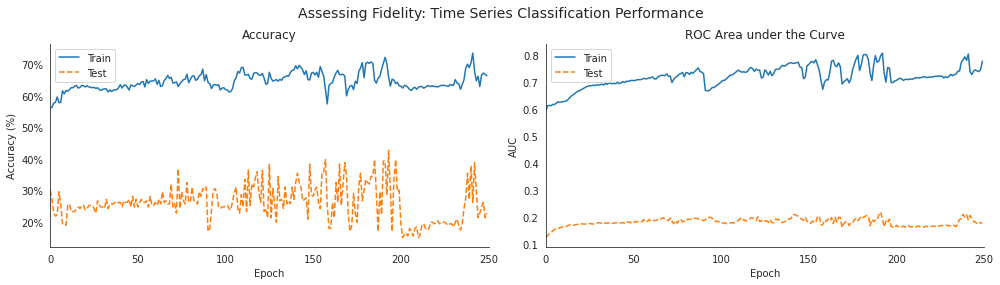

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# Train on Synthetic, test on real: Assessing usefulness

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [ ]:
real_data.shape, synthetic_data.shape

((512, 24, 86), (512, 24, 86))

In [ ]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [ ]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((409, 23, 86), (409, 86), (103, 23, 86), (103, 86))

In [ ]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [ ]:
synthetic_train.shape, synthetic_label.shape

((512, 23, 86), (512, 86))

In [ ]:
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len-1, n_seq)),
                        Dense(86)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [ ]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [ ]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [ ]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

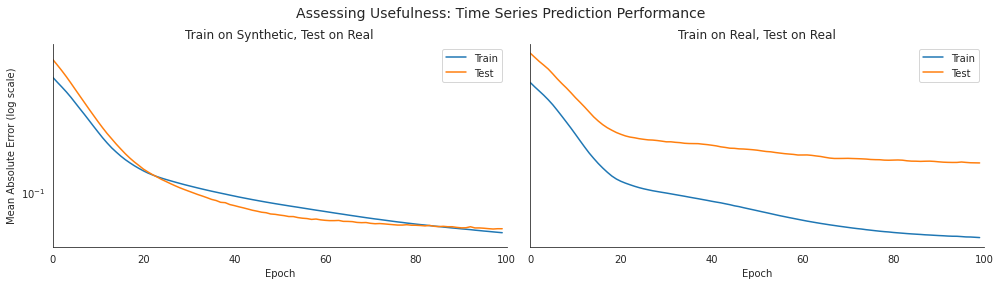

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);